
# Stationary Test


##  ADF Test

In [ ]:
import pandas as pd

# Step 1: Create the date range
date_range = pd.date_range(start='1999-01-01', end='2024-12-31', freq='D')
df_dates = pd.DataFrame({'date': date_range})

# Step 2: Load your AQI + smoothed AQI CSV (assuming you already uploaded it)
aqi_df = pd.read_csv('ready_pm25_fresno_df.csv')  # replace with your path

# Step 3: Check row count difference
print("Date rows:", len(df_dates))
print("AQI rows:", len(aqi_df))

# Step 4 (Optional): If your AQI file has 9498 rows (including header), remove extra row or truncate
aqi_df = aqi_df.iloc[:len(df_dates)]  # truncate to 9497 rows if needed

# Step 5: Merge by row index
merged_df = pd.concat([df_dates, aqi_df.reset_index(drop=True)], axis=1)

# Step 6: Preview merged data
print(merged_df.head())

# Save the merged dataframe to a CSV
merged_df.to_csv('ready_pm25_fresno_with_Date.csv', index=False)

Date rows: 9497
AQI rows: 9497
        date         aqi  aqi_smoothed
0 1999-01-01  108.500000    108.041667
1 1999-01-02  108.500000    107.400000
2 1999-01-03  108.500000    106.666667
3 1999-01-04  106.666667    108.809524
4 1999-01-05  104.833333    104.833333


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 14.5 MB/s eta 0:00:00


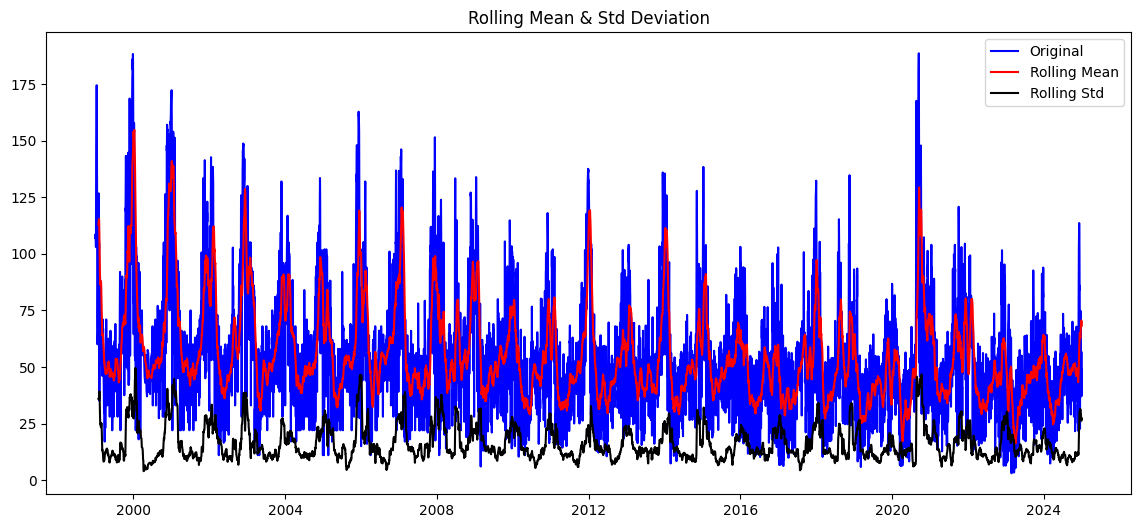


ADF Test:
ADF Statistic : -9.137501669387985
p-value       : 2.908866164109208e-15
Conclusion    : Stationary

KPSS Test:
KPSS Statistic: 2.7751031089503844
p-value       : 0.01
Conclusion    : Non-stationary

Phillips-Perron Test:
Test Statistic: -30.727816853563407
p-value       : 0.0
Conclusion    : Stationary


<ipython-input-27-4c4f4ec1ddf8>:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
# Install required libraries if not already
!pip install statsmodels --quiet
!pip install arch --quiet

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

# Assuming your DataFrame is called merged_df and has a datetime column called 'date'
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.set_index('date', inplace=True)

# Pick the column for testing
series = merged_df['aqi_smoothed'].dropna()

# 1. Visual Inspection
rolling_mean = series.rolling(window=30).mean()
rolling_std = series.rolling(window=30).std()

plt.figure(figsize=(14,6))
plt.plot(series, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Std Deviation')
plt.show()

# 2. Augmented Dickey-Fuller Test
adf_result = adfuller(series)
print("\nADF Test:")
print(f"ADF Statistic : {adf_result[0]}")
print(f"p-value       : {adf_result[1]}")
print("Conclusion    :", "Stationary" if adf_result[1] < 0.05 else "Non-stationary")

# 3. KPSS Test
kpss_result = kpss(series, regression='c', nlags='auto')
print("\nKPSS Test:")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"p-value       : {kpss_result[1]}")
print("Conclusion    :", "Non-stationary" if kpss_result[1] < 0.05 else "Stationary")

# 4. Phillips-Perron Test
pp_test = PhillipsPerron(series)
print("\nPhillips-Perron Test:")
print(f"Test Statistic: {pp_test.stat}")
print(f"p-value       : {pp_test.pvalue}")
print("Conclusion    :", "Stationary" if pp_test.pvalue < 0.05 else "Non-stationary")

 Interpretation:
ADF (Augmented Dickey-Fuller):

Null Hypothesis = Non-stationary

KPSS (Kwiatkowski-Phillips-Schmidt-Shin):

Null Hypothesis = Stationary

PP (Phillips-Perron):

Null Hypothesis = Non-stationary

💡 If ADF & PP say stationary and KPSS says non-stationary, your series is trend-stationary (remove the trend for modeling, like SARIMA does).

# Hypothesis Test


Pre-ISR Mean AQI : 66.12
Post-ISR Mean AQI: 51.47
Pre-ISR Samples  : 2557
Post-ISR Samples : 6940

Welch's t-test:
T-Statistic = 21.4659, P-Value = 0.0000

95% Confidence Interval for Mean Difference (Post - Pre):
[-15.98, -13.31]


<ipython-input-39-0a0b3bc07b03>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pre_isr, label='Pre ISR', shade=True)
<ipython-input-39-0a0b3bc07b03>:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(post_isr, label='Post ISR', shade=True)


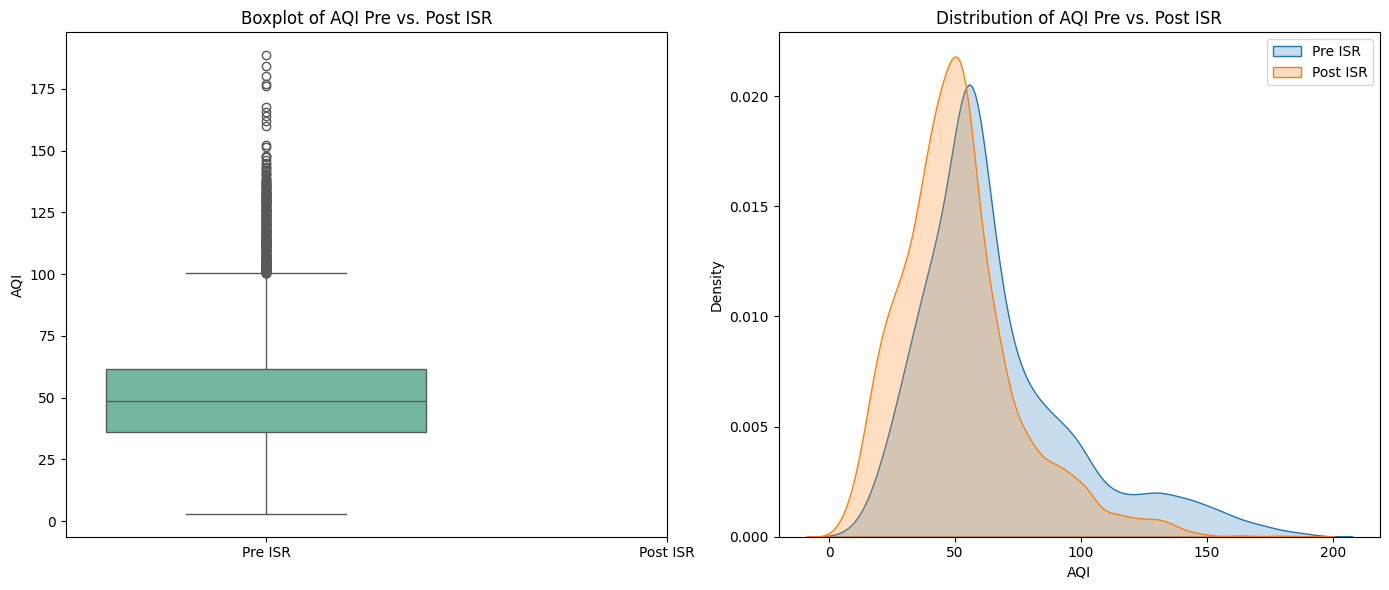

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, t
import matplotlib.pyplot as plt
import seaborn as sns

merged_df = pd.read_csv("ready_pm25_fresno_with_Date.csv")

# Split into Pre-ISR and Post-ISR
pre_isr = merged_df[merged_df['date'] < '2006-01-01']['aqi_smoothed'].dropna()
post_isr = merged_df[merged_df['date'] >= '2006-01-01']['aqi_smoothed'].dropna()

# Descriptive stats
print(f"Pre-ISR Mean AQI : {pre_isr.mean():.2f}")
print(f"Post-ISR Mean AQI: {post_isr.mean():.2f}")
print(f"Pre-ISR Samples  : {len(pre_isr)}")
print(f"Post-ISR Samples : {len(post_isr)}")

# Welch's t-test
t_stat, p_value = ttest_ind(pre_isr, post_isr, equal_var=False)
print(f"\nWelch's t-test:\nT-Statistic = {t_stat:.4f}, P-Value = {p_value:.4f}")

# 95% Confidence Interval for mean difference
mean_diff = post_isr.mean() - pre_isr.mean()
se = np.sqrt(post_isr.var()/len(post_isr) + pre_isr.var()/len(pre_isr))
df = (post_isr.var()/len(post_isr) + pre_isr.var()/len(pre_isr))**2 / \
     ((post_isr.var()/len(post_isr))**2/(len(post_isr)-1) + (pre_isr.var()/len(pre_isr))**2/(len(pre_isr)-1))
ci_low = mean_diff - t.ppf(0.975, df) * se
ci_high = mean_diff + t.ppf(0.975, df) * se

print(f"\n95% Confidence Interval for Mean Difference (Post - Pre):")
print(f"[{ci_low:.2f}, {ci_high:.2f}]")

# --- Visuals ---
plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=[pre_isr, post_isr], palette='Set2')
plt.xticks([0, 1], ['Pre ISR', 'Post ISR'])
plt.ylabel('AQI')
plt.title('Boxplot of AQI Pre vs. Post ISR')

# KDE Plot
plt.subplot(1, 2, 2)
sns.kdeplot(pre_isr, label='Pre ISR', shade=True)
sns.kdeplot(post_isr, label='Post ISR', shade=True)
plt.title('Distribution of AQI Pre vs. Post ISR')
plt.xlabel('AQI')
plt.legend()

plt.tight_layout()
plt.show()


# SARIMA

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 23.53
RMSE: 30.83
R² Score: -0.69


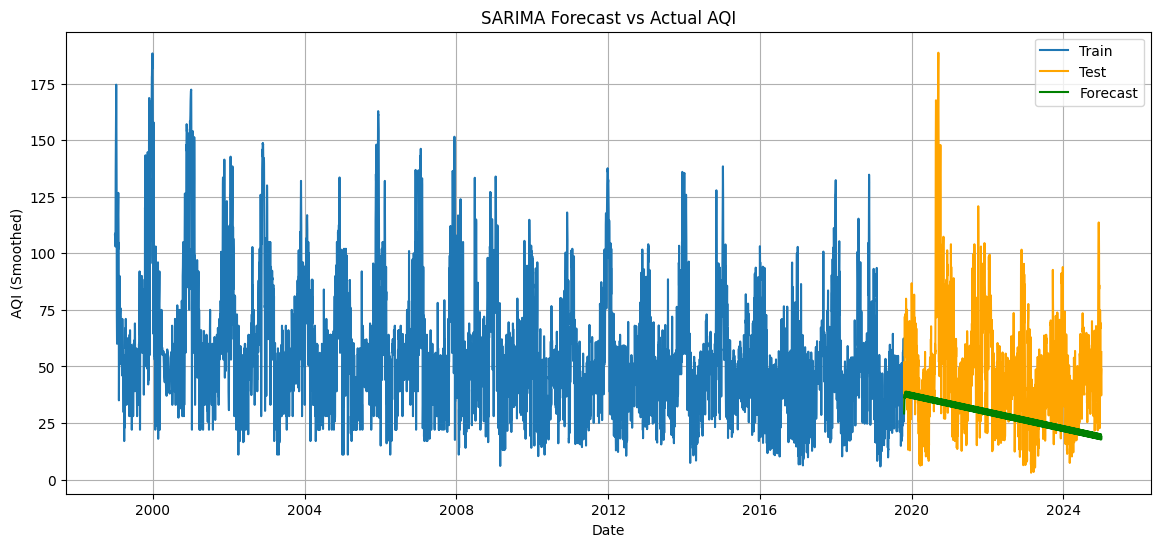

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
merged_df = pd.read_csv("ready_pm25_fresno_with_Date.csv")
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df.sort_values('date')
merged_df.set_index('date', inplace=True)

# Target series
series = merged_df['aqi_smoothed'].dropna()

# Train/test split
split = int(len(series) * 0.8)
train, test = series.iloc[:split], series.iloc[split:]

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming train/test are defined
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Forecast
forecast = results.forecast(steps=len(test))

# Metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title('SARIMA Forecast vs Actual AQI')
plt.xlabel('Date')
plt.ylabel('AQI (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

